In [2]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import cv2
import os

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
os.getcwd()


'/home/cross/Fab2Alex.github.io/_notebooks'

In [13]:
data_dir  = "/home/cross/hymenoptera_data"

In [16]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
image_datasets.keys()

dict_keys(['train', 'val'])

In [22]:
image_datasets["train"]

Dataset ImageFolder
    Number of datapoints: 244
    Root location: /home/cross/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [24]:
image_datasets["val"]

Dataset ImageFolder
    Number of datapoints: 153
    Root location: /home/cross/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
dataset_sizes

{'train': 244, 'val': 153}

In [20]:
class_names

['ants', 'bees']

In [41]:
for i in os.listdir(data_dir+"/train/ants/"):
    print(i)

957233405_25c1d1187b.jpg
707895295_009cf23188.jpg
533848102_70a85ad6dd.jpg
408393566_b5b694119b.jpg
506249836_717b73f540.jpg
2288450226_a6e96e8fdf.jpg
522415432_2218f34bf8.jpg
392382602_1b7bed32fa.jpg
1808777855_2a895621d7.jpg
148715752_302c84f5a4.jpg
82852639_52b7f7f5e3.jpg
188552436_605cc9b36b.jpg
swiss-army-ant.jpg
403746349_71384f5b58.jpg
trap-jaw-ant-insect-bg.jpg
384191229_5779cf591b.jpg
196057951_63bf063b92.jpg
1286984635_5119e80de1.jpg
1095476100_3906d8afde.jpg
459694881_ac657d3187.jpg
649026570_e58656104b.jpg
hormiga_co_por.jpg
154124431_65460430f2.jpg
116570827_e9c126745d.jpg
382971067_0bfd33afe0.jpg
termite-vs-ant.jpg
150801171_cd86f17ed8.jpg
424119020_6d57481dab.jpg
1262877379_64fcada201.jpg
255434217_1b2b3fe0a4.jpg
938946700_ca1c669085.jpg
178538489_bec7649292.jpg
531979952_bde12b3bc0.jpg
892108839_f1aad4ca46.jpg
450057712_771b3bfc91.jpg
339670531_94b75ae47a.jpg
1660097129_384bf54490.jpg
541630764_dbd285d63c.jpg
684133190_35b62c0c1d.jpg
2265824718_2c96f485da.jpg
522163566_

In [48]:
# to do: how to calculate the mean of a dataset


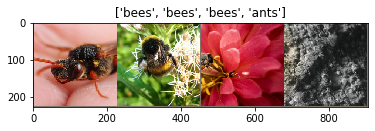

In [51]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [54]:
#fine tune
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/cross/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.89MB/s]


In [55]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6098 Acc: 0.6639
val Loss: 0.1915 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.6551 Acc: 0.7213
val Loss: 0.4594 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.5606 Acc: 0.7951
val Loss: 0.4373 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.5468 Acc: 0.7746
val Loss: 0.3297 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4574 Acc: 0.8402
val Loss: 0.2777 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.6163 Acc: 0.7705
val Loss: 0.3657 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.5513 Acc: 0.7951
val Loss: 0.3573 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.2964 Acc: 0.8607
val Loss: 0.2944 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3848 Acc: 0.8484
val Loss: 0.2856 Acc: 0.8693

Epoch 9/24
----------
train Loss: 0.3001 Acc: 0.8525
val Loss: 0.2536 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.2601 Acc: 0.9016
val Loss: 0.2507 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3829 Acc: 0.8156
val Loss: 0.3014 Acc: 0.8497

Ep

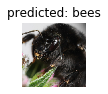

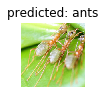

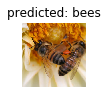

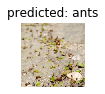

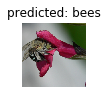

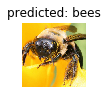

In [56]:
visualize_model(model_ft)